## test+train的Fat data全用來當word2vec的訓練文本
## 不考慮出現"not"的情況( "not" 在model中相關字的意思和"not"沒有太大相關性)

In [1]:
from os import listdir
from os.path import isfile, isdir, join
from collections import Counter
import csv
import numpy
import pandas as pd
from gensim.models.word2vec import Word2Vec
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


from data_preprocess import content_fraction
from Dataloader import dataloader

In [2]:
train_data_path = "..\Case_Presentation_1_Data\Train_Textual\\"
test_data_path  = "..\Case_Presentation_1_Data\Test_Intuitive\\"

train_data = dataloader(train_data_path)
test_data  = dataloader(test_data_path)

In [3]:
#print(train_data.text_list[0])

### 取train data和test data中"非肥胖"的text

In [4]:
model = Word2Vec(train_data.text_list[200:400])

In [5]:
#定義相關性
def similar(w2v_model, word, target, topn=10):
        try:
            return w2v_model.wv.similarity(word, target)
        except:
            return 0

In [6]:
#找和 words相關性最大的前 [topn] 個字
def most_similar(w2v_model, words, topn=20):
    similar_df = pd.DataFrame()
    for word in words:
        try:
            similar_words = pd.DataFrame(w2v_model.wv.most_similar(word, topn=topn), columns=[word, 'cos'])
            similar_df = pd.concat([similar_df, similar_words], axis=1)
        except:
            print(word, "not found in Word2Vec model!")
    return similar_df

### 和"not"相關的前幾個字和"not"本身文義不相關

In [7]:
print(most_similar(model, ["not"]))

                   not       cos
0   treatmentsprocedur  0.891520
1                 none  0.888835
2              remaind  0.887885
3                brief  0.887495
4               detail  0.868968
5              uncompl  0.866470
6               commun  0.860262
7               memori  0.858205
8             procedur  0.855066
9              univers  0.846669
10                oper  0.844156
11         colonoscopi  0.839133
12              hospit  0.836722
13               refer  0.833603
14               avail  0.833571
15               evalu  0.832953
16               cours  0.825555
17               taken  0.825034
18               resum  0.821735
19             consult  0.821729


In [8]:
print(most_similar(model, ["hypercholesterolemia"]))

   hypercholesterolemia       cos
0        hyperlipidemia  0.995337
1                factor  0.989362
2                anemia  0.988228
3         gastroesophag  0.987952
4        cardiomyopathi  0.985608
5        nephrolithiasi  0.984063
6                mother  0.982534
7                father  0.981661
8                  cabg  0.981584
9                 adult  0.981304
10                 copd  0.981020
11              depress  0.980959
12               asthma  0.980341
13               reflux  0.980335
14             arthriti  0.979792
15                 risk  0.979621
16               surgic  0.979477
17              endstag  0.978889
18               vessel  0.978726
19              gastric  0.978613


In [9]:
print(most_similar(model, ["angina"]))

            angina       cos
0          unstabl  0.989770
1        pneumonia  0.985025
2           stroke  0.984644
3            bleed  0.984585
4            chief  0.983482
5        complaint  0.978988
6           vessel  0.976278
7          diagnos  0.976208
8   cardiomyopathi  0.976148
9             copd  0.974914
10          recent  0.974192
11         problem  0.973768
12    appendectomi  0.973054
13         exacerb  0.972557
14           pacer  0.972484
15         biliari  0.971244
16          cellul  0.970227
17          nstemi  0.970166
18            cabg  0.969774
19      transplant  0.969228


---------------------------------------------------------------------------------------------------------------------------

## 計分方式

In [10]:
def score(datakind, gap, target_word):
    score=0
    total = 0
    for text in datakind:
        for word in text:
            if similar(model, word,  target_word)>gap:
                score+=similar(model, word, target_word)
        total+=score
        score=0
    average = total/200
    return average

### [gap]定義在大於多少相識性時要承認
### [target_word]定義要以哪個字為中心找相關性

In [11]:
gap = 0.85
target_word = "angina"

# Train data

## 不肥胖

In [12]:
train_unfat_score = score(train_data.text_list[0:200], gap, target_word)
print("train_unfat_score: ",train_unfat_score)

train_unfat_score:  128.3852070260048


## 肥胖

In [13]:
train_fat_score = score(train_data.text_list[200:400], gap, target_word)
print("train_fat_score: ",train_fat_score)

train_fat_score:  142.17170567423105


# Test data

## 不肥胖

In [14]:
test_unfat_score = score(test_data.text_list[0:200], gap, target_word)
print("test_unfat_score: ",test_unfat_score)

test_unfat_score:  131.70643821328878


## 肥胖

In [15]:
test_fat_score =score(test_data.text_list[200:400], gap, target_word)
print("test_fat_score: ",test_fat_score)

test_fat_score:  132.38489142209292


In [16]:
upper = (train_fat_score+test_fat_score)/2
print("upper: ",upper)

upper:  137.27829854816198


In [17]:
lower =  (train_unfat_score+test_unfat_score)/2
print("lower: ",lower)

lower:  130.0458226196468


### standard 建立判斷文章是否為Fat 的標準分數。 大於standard即為Fat，反之不是

In [18]:
standard = (upper+lower)/2
print("standard: ",standard)

standard:  133.6620605839044


---------------------------------------------------------------------------------------------------------------------------

# Validation

In [19]:
validation_data_path  = "..\Case_Presentation_1_Data\Validation\\"
validation_data  = dataloader(validation_data_path)

In [20]:
score(validation_data.text_list, gap, target_word)

36.33191667795181

In [21]:
score=0
ans = []
for text in validation_data.text_list:
    for word in text:
        if similar(model, word,  target_word)>gap:
            score+=similar(model, word, target_word)
    if score>standard:
        ans.append(0)
    else:
        ans.append(1)
    score=0

print(len(ans))

50


In [22]:
print(ans)

[0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]


In [23]:
len(validation_data.text_list)

50

---------------------------------------------------------------------------------------------------------------------------

# confusion matrix & F1-score

In [24]:
from sklearn.metrics import confusion_matrix

def precision(matrix):
    return matrix[0,0]/(matrix[0,0]+matrix[0,1])

def recall(matrix):
    return matrix[0,0]/(matrix[0,0]+matrix[1,0])


def f1(matrix):
    return (2*precision(matrix)*recall(matrix))/(precision(matrix)+recall(matrix))


def confusionMatix(matrix, title):
    sns.set()
    f,ax=plt.subplots()
    #y_true = label
    #y_pred = ans
    sns.heatmap(matrix,annot=True,ax=ax, cmap = plt.cm.Blues) #畫熱力圖

    ax.set_title(title) #標題
    ax.set_xlabel('predict') #x軸
    ax.set_ylabel('true') #y軸

def print_result(matrix, title):
    print("precision: ",precision(matrix))
    print("recall: ",recall(matrix))
    print("F1-Score: ",f1(matrix))
    confusionMatix(matrix, title)
    
        

---------------------------------------------------------------------------------------------------------------------------

## train data

In [25]:
train_data_path  = "..\Case_Presentation_1_Data\Train_Textual\\"
train_data  = dataloader(train_data_path)
score=0
train_ans = []
for text in train_data.text_list:
    for word in text:
        if similar(model, word,  target_word)>gap:
            score+=similar(model, word, target_word)
    if score>standard:
        train_ans.append(0)
    else:
        train_ans.append(1)
    score=0

In [26]:
train_y_true = train_data.label_list
train_y_pred = train_ans

train_confusion_matrix = confusion_matrix(train_y_true, train_y_pred)
tmp = numpy.empty((2,2), dtype=float)

for i in range(2):
    for j in range(2):
        tmp[i][j] = float(train_confusion_matrix[i][j])/200
train_confusion_matrix = tmp

precision:  0.39
recall:  0.4508670520231214
F1-Score:  0.41823056300268097


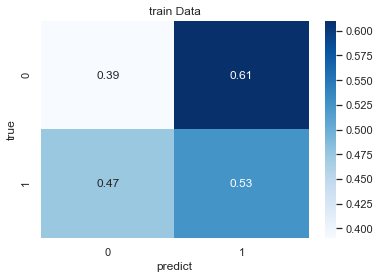

In [27]:
print_result(train_confusion_matrix, "train Data")

## test data

In [28]:
test_data_path  = "..\Case_Presentation_1_Data\Test_Intuitive\\"
test_data  = dataloader(test_data_path)
score=0
test_ans = []

for text in test_data.text_list:
    for word in text:
        if similar(model, word,  target_word)>gap:
            score+=similar(model, word, target_word)
    if score>standard:
        test_ans.append(0)
    else:
        test_ans.append(1)
    score=0

In [29]:
test_y_true = test_data.label_list
test_y_pred = test_ans

test_confusion_matrix = confusion_matrix(test_y_true, test_y_pred)
tmp = numpy.empty((2,2), dtype=float)

for i in range(2):
    for j in range(2):
        tmp[i][j] = float(test_confusion_matrix[i][j])/200
test_confusion_matrix = tmp

precision:  0.42
recall:  0.49411764705882355
F1-Score:  0.4540540540540541


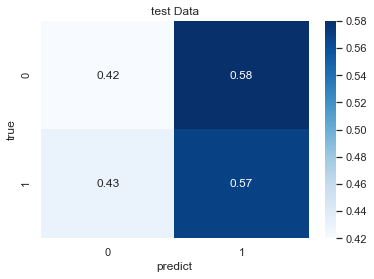

In [30]:
print_result(test_confusion_matrix, "test Data")